In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('wine.data.csv')
df.head()

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
df_filtered = df.iloc[99:158]
first_column = df_filtered.iloc[:, 0]  # Gets all rows for the fourth column (index starts at 0)
counts = first_column.value_counts()
print(counts)

Class
2    31
3    28
Name: count, dtype: int64


In [5]:
df_filtered2 = df.iloc[0:59]
first_column = df_filtered2.iloc[:, 0]  # Gets all rows for the fourth column (index starts at 0)
counts = first_column.value_counts()
print(counts)

Class
1    59
Name: count, dtype: int64


In [6]:
combined_df = pd.concat([df_filtered2, df_filtered], ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
combined_df.to_csv("combined_data.csv", index=False)


In [7]:
df = pd.read_csv('combined_data.csv')
df['Class'] = df['Class'].apply(lambda x: 0 if x != 1 else 1)
first_column = df.iloc[:, 0]  # Gets all rows for the fourth column (index starts at 0)
counts = first_column.value_counts()
print(counts)

Class
1    59
0    59
Name: count, dtype: int64


In [8]:
X = torch.tensor(df[['Alcohol', 'Malic acid']].values, dtype=torch.float)
y = torch.tensor(df['Class'].values, dtype = torch.float)
torch.manual_seed(123) 
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)   # y.size(0) =178
X, y = X[shuffle_idx], y[shuffle_idx]
percent70 = int(shuffle_idx.size(0)*0.7)

X_train, X_test = X[shuffle_idx[:percent70]], X[shuffle_idx[percent70:]]
y_train, y_test = y[shuffle_idx[:percent70]], y[shuffle_idx[percent70:]]

# Normalize (mean zero, unit variance)

mu, sigma = X_train.mean(dim=0), X_train.std(dim=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

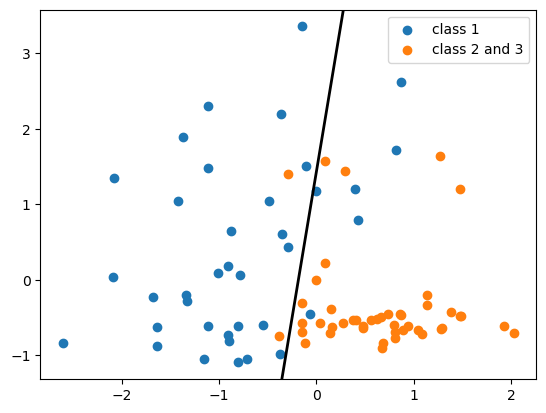

In [51]:
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], label='class 1')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='class 2 and 3')
plt.axline((0, model.bias[0]+ model.weights[0][0]*2.64), (model.weights[1][0], model.weights[0][0]), linewidth=2, color='black')

plt.legend()
plt.show()


In [59]:
print(model.weights[1][0])
print(model.weights[0][0])

tensor(-0.1412)
tensor(0.3435)


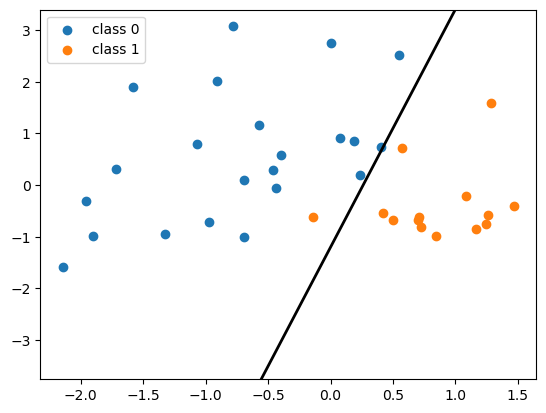

In [131]:
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], label='class 0')
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], label='class 1')
plt.axline((0,-model.weights[0][0]*3.5), (-model.weights[0][0] + model.weights[1][0], -model.weights[0][0] *10 ), linewidth=2, color='black')
plt.legend()
plt.show()

In [10]:
class Adaline1():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float)
        self.bias = torch.zeros(1, dtype=torch.float)

    def forward(self, x):
        netinputs = torch.add(torch.mm(x, self.weights), self.bias)  # compute net inputs 
        activations = netinputs
        return activations.view(-1)
        
    def backward(self, x, yhat, y):   
        
        grad_loss_yhat = 2*(yhat - y)    
        
        grad_yhat_weights = x
        grad_yhat_bias = 1.
        
        grad_loss_weights = torch.mm(grad_yhat_weights.t(),
                                         grad_loss_yhat.view(-1, 1)) / y.size(0)

        grad_loss_bias = torch.sum(grad_yhat_bias*grad_loss_yhat) / y.size(0)
        
        # return negative gradient
        return (-1)*grad_loss_weights, (-1)*grad_loss_bias

In [11]:


def loss(yhat, y):
    return torch.mean(0.5*(yhat - y)**2)


def train(model, x, y, num_epochs,
          learning_rate=0.01, seed=123, minibatch_size=10):
    cost = []
    
    torch.manual_seed(seed)
    for e in range(num_epochs):
        
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            #### Compute outputs ####
            yhat = model.forward(x[minibatch_idx])

            #### Compute gradients ####
            negative_grad_w, negative_grad_b = \
                model.backward(x[minibatch_idx], yhat, y[minibatch_idx])

            #### Update weights ####
            model.weights += learning_rate * negative_grad_w
            model.bias += learning_rate * negative_grad_b
            
            #### Logging ####
            minibatch_loss = loss(yhat, y[minibatch_idx])
            print('    Minibatch MSE: %.3f' % minibatch_loss)

        #### Logging ####
        yhat = model.forward(x)
        curr_loss = loss(yhat, y)
        print('Epoch: %03d' % (e+1), end="")
        print(' | MSE: %.5f' % curr_loss)
        cost.append(curr_loss)

    return cost

In [12]:
model = Adaline1(num_features=X_train.size(1))
cost = train(model, 
             X_train, y_train.float(),
             num_epochs=30,
             learning_rate=0.1,
             seed=123,
             minibatch_size=15)

    Minibatch MSE: 0.300
    Minibatch MSE: 0.202
    Minibatch MSE: 0.093
    Minibatch MSE: 0.146
    Minibatch MSE: 0.069
    Minibatch MSE: 0.080
Epoch: 001 | MSE: 0.06527
    Minibatch MSE: 0.061
    Minibatch MSE: 0.068
    Minibatch MSE: 0.052
    Minibatch MSE: 0.060
    Minibatch MSE: 0.059
    Minibatch MSE: 0.023
Epoch: 002 | MSE: 0.04893
    Minibatch MSE: 0.050
    Minibatch MSE: 0.052
    Minibatch MSE: 0.050
    Minibatch MSE: 0.048
    Minibatch MSE: 0.032
    Minibatch MSE: 0.078
Epoch: 003 | MSE: 0.04791
    Minibatch MSE: 0.049
    Minibatch MSE: 0.046
    Minibatch MSE: 0.029
    Minibatch MSE: 0.061
    Minibatch MSE: 0.033
    Minibatch MSE: 0.113
Epoch: 004 | MSE: 0.04983
    Minibatch MSE: 0.074
    Minibatch MSE: 0.033
    Minibatch MSE: 0.066
    Minibatch MSE: 0.030
    Minibatch MSE: 0.049
    Minibatch MSE: 0.048
Epoch: 005 | MSE: 0.04867
    Minibatch MSE: 0.047
    Minibatch MSE: 0.056
    Minibatch MSE: 0.049
    Minibatch MSE: 0.061
    Minibatch MSE: 0

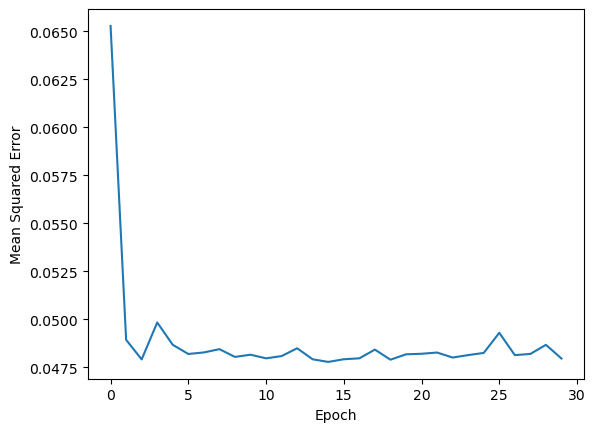

In [13]:
plt.plot(range(len(cost)), cost)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()